In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [3]:
full_adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/211015_annot_patient_integrated.h5ad')
full_adata = full_adata[full_adata.obs.treatment != 'nan']
full_adata.obs['treatment'] = full_adata.obs.treatment.replace({'IFNa (b_d)':'IFNa'})

Trying to set attribute `.obs` of view, copying.


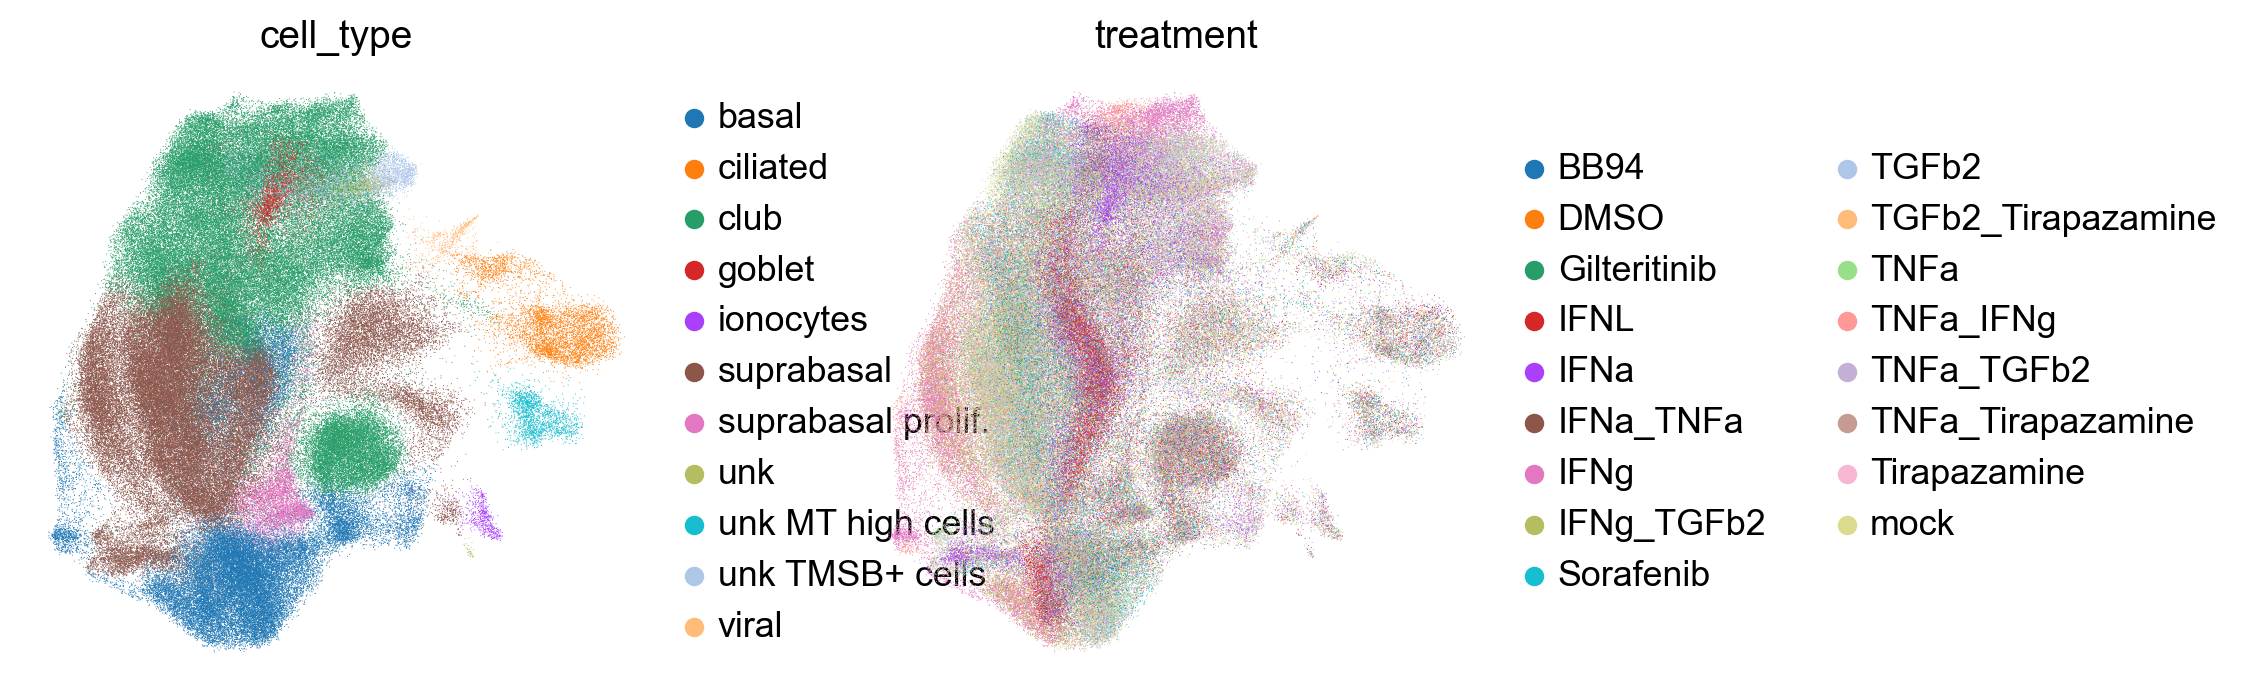

In [5]:
sc.pl.umap(full_adata, color=['cell_type', 'treatment'])

In [6]:
# sc.pp.subsample(full_adata, .5)
# full_adata

In [8]:
# subset to only 1 cell type
adata = full_adata[full_adata.obs.cell_type.isin(['club', 'goblet', 'unk TMSB+ cells'])]
adata

View of AnnData object with n_obs × n_vars = 94093 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', 'celltype_fine'
    var: 'used_for_scvi'
    uns: '_scvi', 'cell_type_colors', 'celltype_fine_colors', 'hvg', 'infected_colors', 'leiden', 'neighbors', 'patient_colors', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [32]:
adata.obs.treatment.value_counts()

mock                  13773
IFNa                  10797
TNFa                   8668
TGFb2                  8631
IFNg                   7652
IFNa_TNFa              6969
Tirapazamine           6879
TNFa_Tirapazamine      6011
Sorafenib              5478
TNFa_TGFb2             4693
TNFa_IFNg              4562
IFNL                   3279
TGFb2_Tirapazamine     1914
IFNg_TGFb2             1692
BB94                   1231
Gilteritinib           1099
DMSO                    765
Name: treatment, dtype: int64

### fit linear combination model on each label

In [9]:
def convert_to_means(adata, groupby):
    # convert to a dataframe to use groupby
    df_exp = adata.to_df()
    df_exp[groupby] = adata.obs[groupby]

    # convert back into an AnnData for syntactical familiarity
    mean_adata = ad.AnnData(df_exp.groupby(groupby).mean())
    return mean_adata

from sklearn.preprocessing import OneHotEncoder

def get_onehot_enc(cmpds):
    """
    Params
    ------
    cmpds : list

    """
    # fit a one-hot encoding using the list of unique compounds
    ohe = OneHotEncoder()
    ohe.fit(np.array(cmpds).reshape(-1, 1))
    return ohe

def get_onehot_mat(ohe, cmpds):
    """
    Params
    ------
    ohe : sklearn.preprocessing.OneHotEncoder
    cmpds : np.array
        Vertical array of shape (n_conditions, 1).

    Returns
    -------
    A one-hot encoded matrix of shape (n_conditions, len(cmpds)).
    """
    print('creating one-hot encoding matrix')
    # encode the first compound and the 2nd compound separately and add together
    ohe_mat = []
    for c in cmpds:
        if '+' in c:
            c1 = [c.split('+')[0]]
            c2 = [c.split('+')[1]]
            ohe_mat.append(ohe.transform([c1, c2]).sum(axis=0))
        else:
            ohe_mat.append(ohe.transform([[c]]).toarray())
    return np.concatenate(ohe_mat)

def fit_means(train_adata, ctrl_adata, ohe_mat):
    print('fitting data')
    gene_fits = []
    for gene in train_adata.var_names:
        y = train_adata[:, gene].copy().X.reshape(-1) # means of perturbed data for a single gene

        x = ohe_mat*ctrl_adata[:, gene].X[0][0] # mean of gene in ctrl
        A = np.concatenate([x.T, np.ones([1, x.shape[0]])]).T  # add 1 to the end to represent a constant. If you have a better way of doing this, please do suggest.
#         A = x.toarray()

        gene_fits.append(np.linalg.lstsq(A, y, rcond=None)[0])

    coeffs = np.array(gene_fits)[:, :-1]
#     coeffs = np.array(gene_fits)
    constants = np.array(gene_fits)[:, -1]

    return coeffs, constants
#     return coeffs

In [10]:
%%time
groupby = 'treatment'
train_adata = convert_to_means(adata, groupby)
ctrl_adata = convert_to_means(adata[adata.obs[groupby] == 'mock'], groupby)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


CPU times: user 10.1 s, sys: 1min 24s, total: 1min 34s
Wall time: 1min 36s


In [7]:
# from functools import reduce
# unique_cmpds = list(set(reduce(lambda x, y: x+y, [c.split('+') for c in adata.obs[groupby].unique()])))

# ohe = get_onehot_enc(unique_cmpds)
# ohe_mat = get_onehot_mat(ohe, train_adata.obs.index)
# ohe_mat.shape

In [11]:
unique_cmpds = adata.obs[groupby].cat.categories

ohe = get_onehot_enc(unique_cmpds)
ohe_mat = get_onehot_mat(ohe, train_adata.obs.index)
ohe_mat.shape

creating one-hot encoding matrix


(17, 17)

In [12]:
coeffs, constants = fit_means(train_adata, ctrl_adata, ohe_mat)

fitting data


In [13]:
import gc
gc.collect()

6598

In [18]:
coef_adata_df = ad.AnnData(coeffs.T, var=adata.var, obs=pd.DataFrame(ohe.categories_).T.set_index(0)).to_df().T

### fit classification model instead

In [33]:
%%time
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(adata.X.toarray(), adata.obs['treatment'].values)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


CPU times: user 25min, sys: 4min 52s, total: 29min 52s
Wall time: 2min 23s


LogisticRegression()

In [34]:
coef_adata_df = ad.AnnData(clf.coef_, var=adata.var, obs=pd.DataFrame(clf.classes_).set_index(0)).to_df().T

<Figure size 1000x800 with 0 Axes>

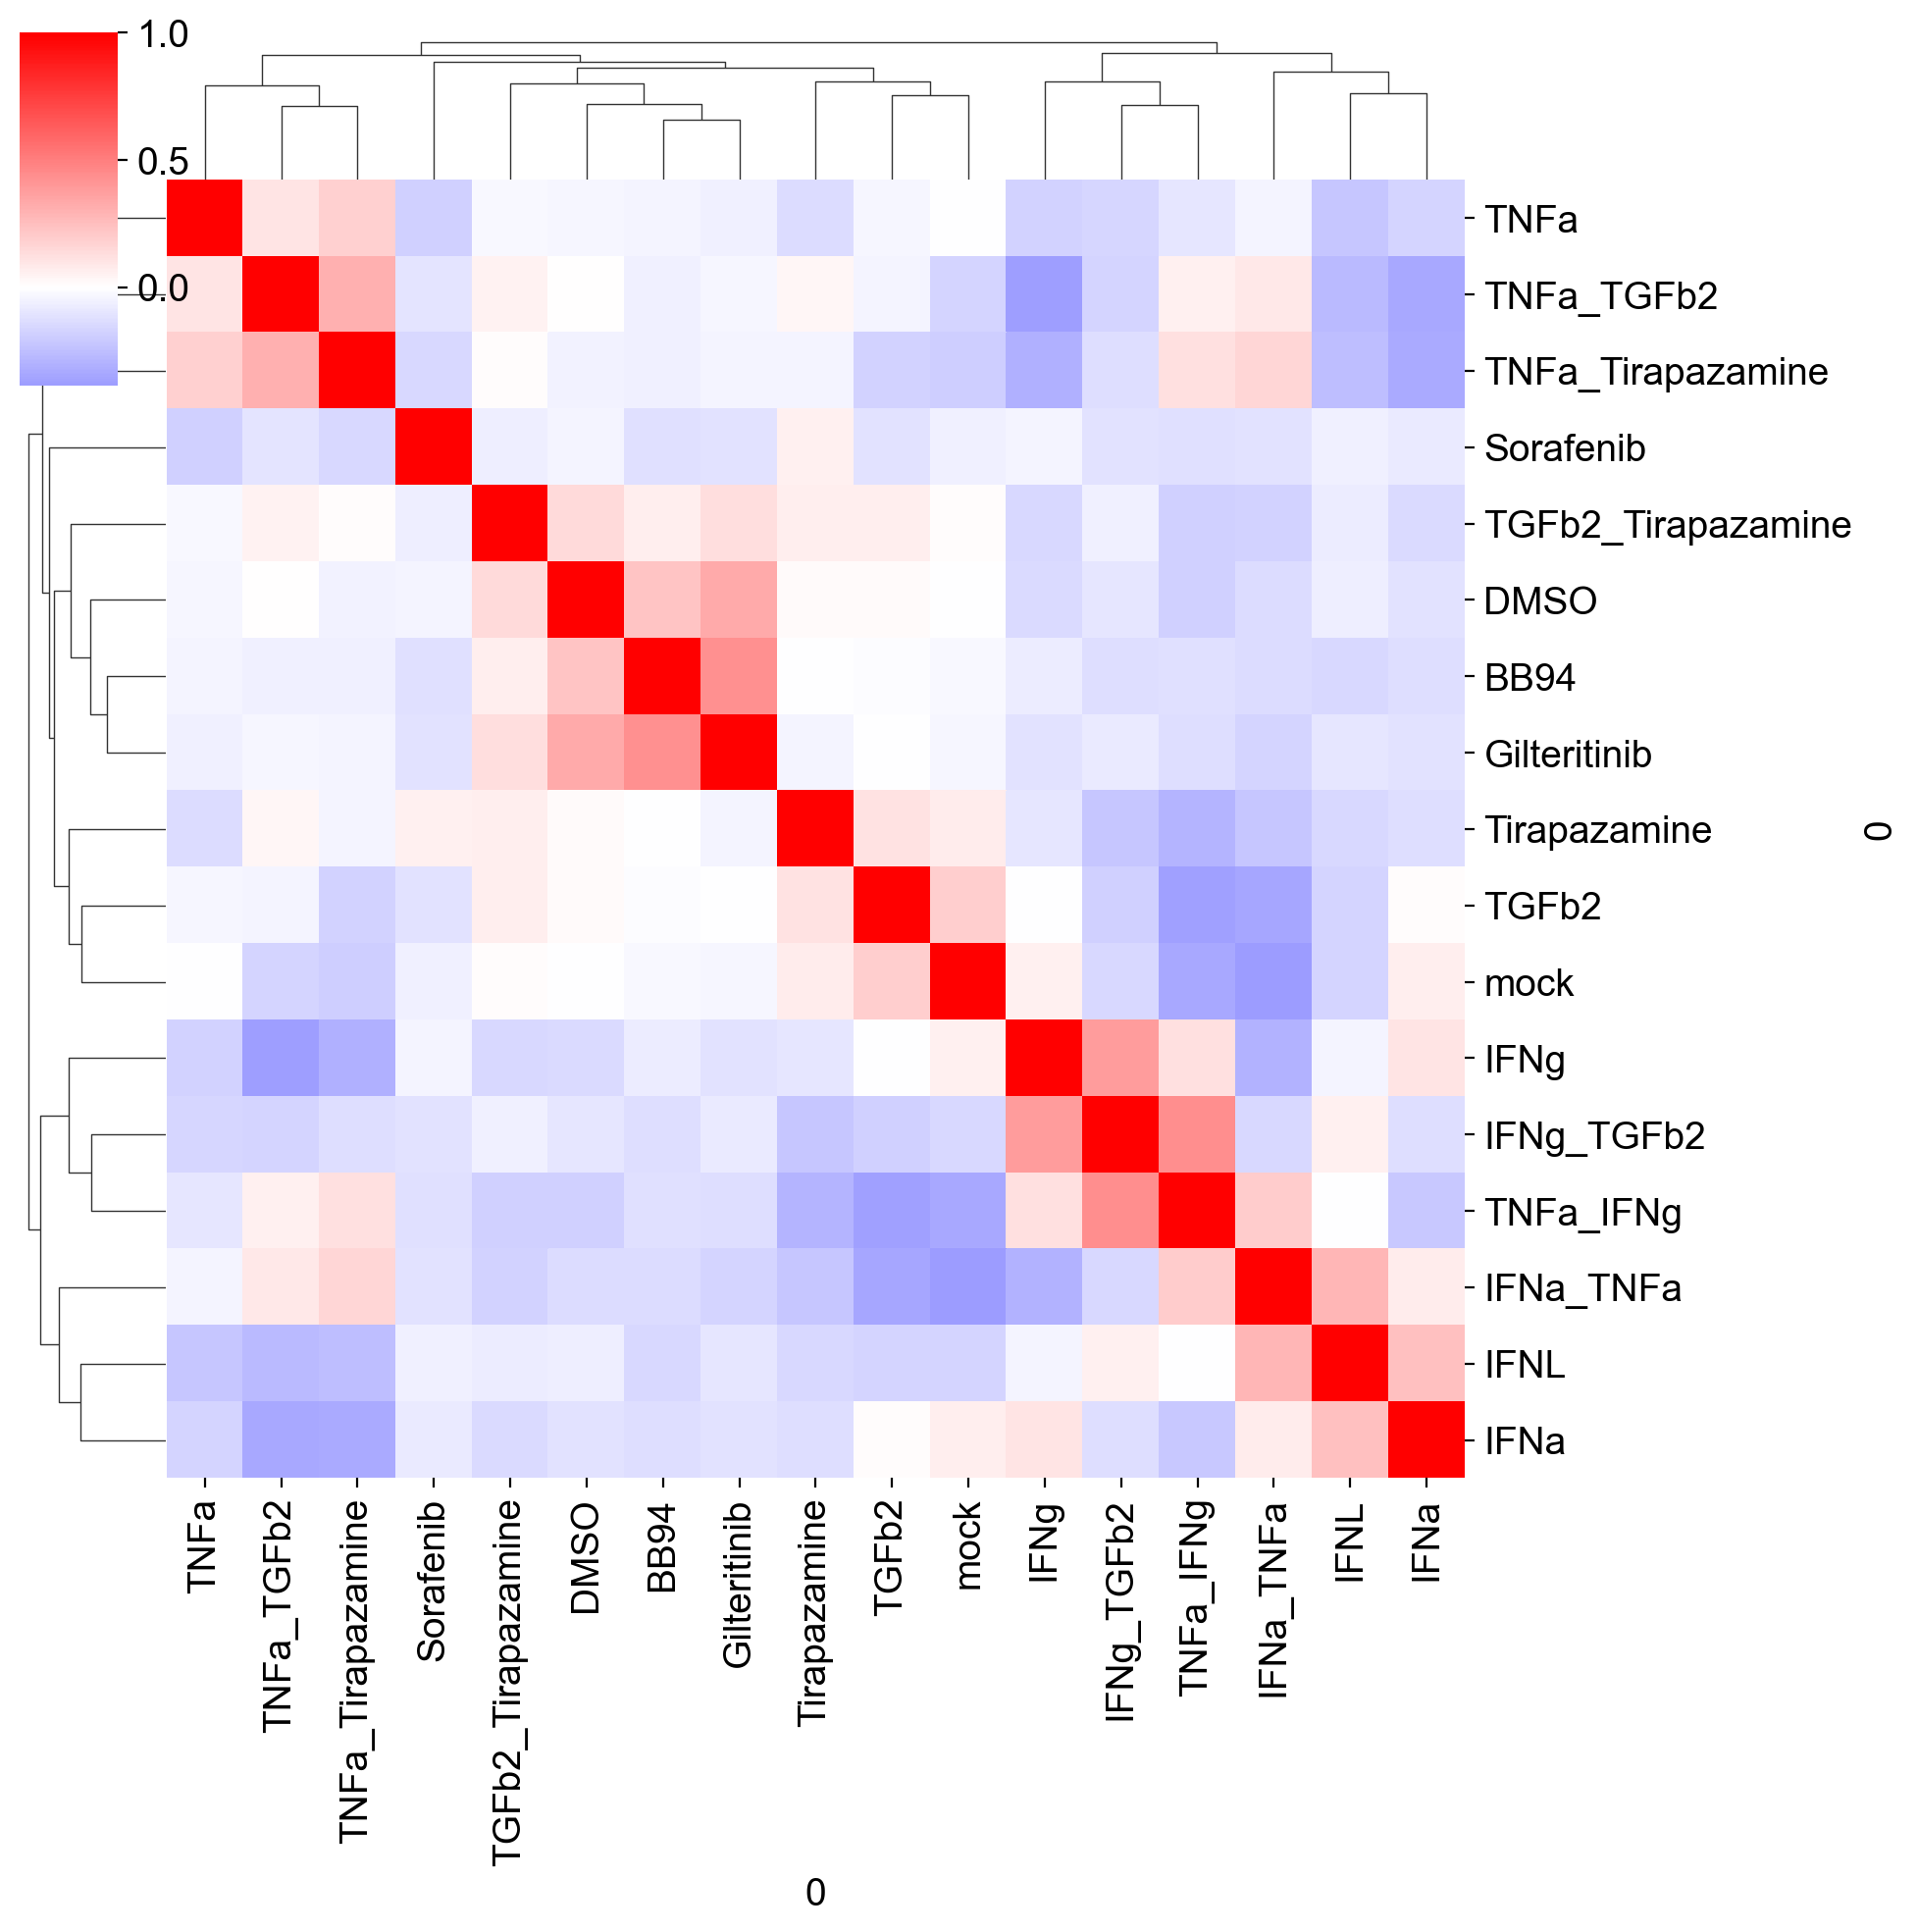

In [36]:
plt.figure(figsize=(10, 8))
sns.clustermap(coef_adata_df.corr('pearson'), cmap='bwr', center=0, dendrogram_ratio=.1)

### take difference between coefficients

In [38]:
%%time
clf_ctrl = LogisticRegression()
clf_ctrl.fit(adata[adata.obs.infected == 'False'].X.toarray(), adata[adata.obs.infected == 'False'].obs['treatment'].values)

CPU times: user 13min 35s, sys: 1min 11s, total: 14min 46s
Wall time: 50.1 s


/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [39]:
clf_inf = LogisticRegression()
clf_inf.fit(adata[adata.obs.infected == 'True'].X.toarray(), adata[adata.obs.infected == 'True'].obs['treatment'].values)

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [51]:
coef_adata_df = pd.concat([
    ad.AnnData(clf_inf.coef_,  var=adata.var, obs=pd.DataFrame(clf_inf.classes_).set_index(0)).to_df().T.add_suffix('_inf'),
    ad.AnnData(clf_ctrl.coef_, var=adata.var, obs=pd.DataFrame(clf_ctrl.classes_).set_index(0)).to_df().T.add_suffix('_ctrl')
], axis=1)

<Figure size 1000x800 with 0 Axes>

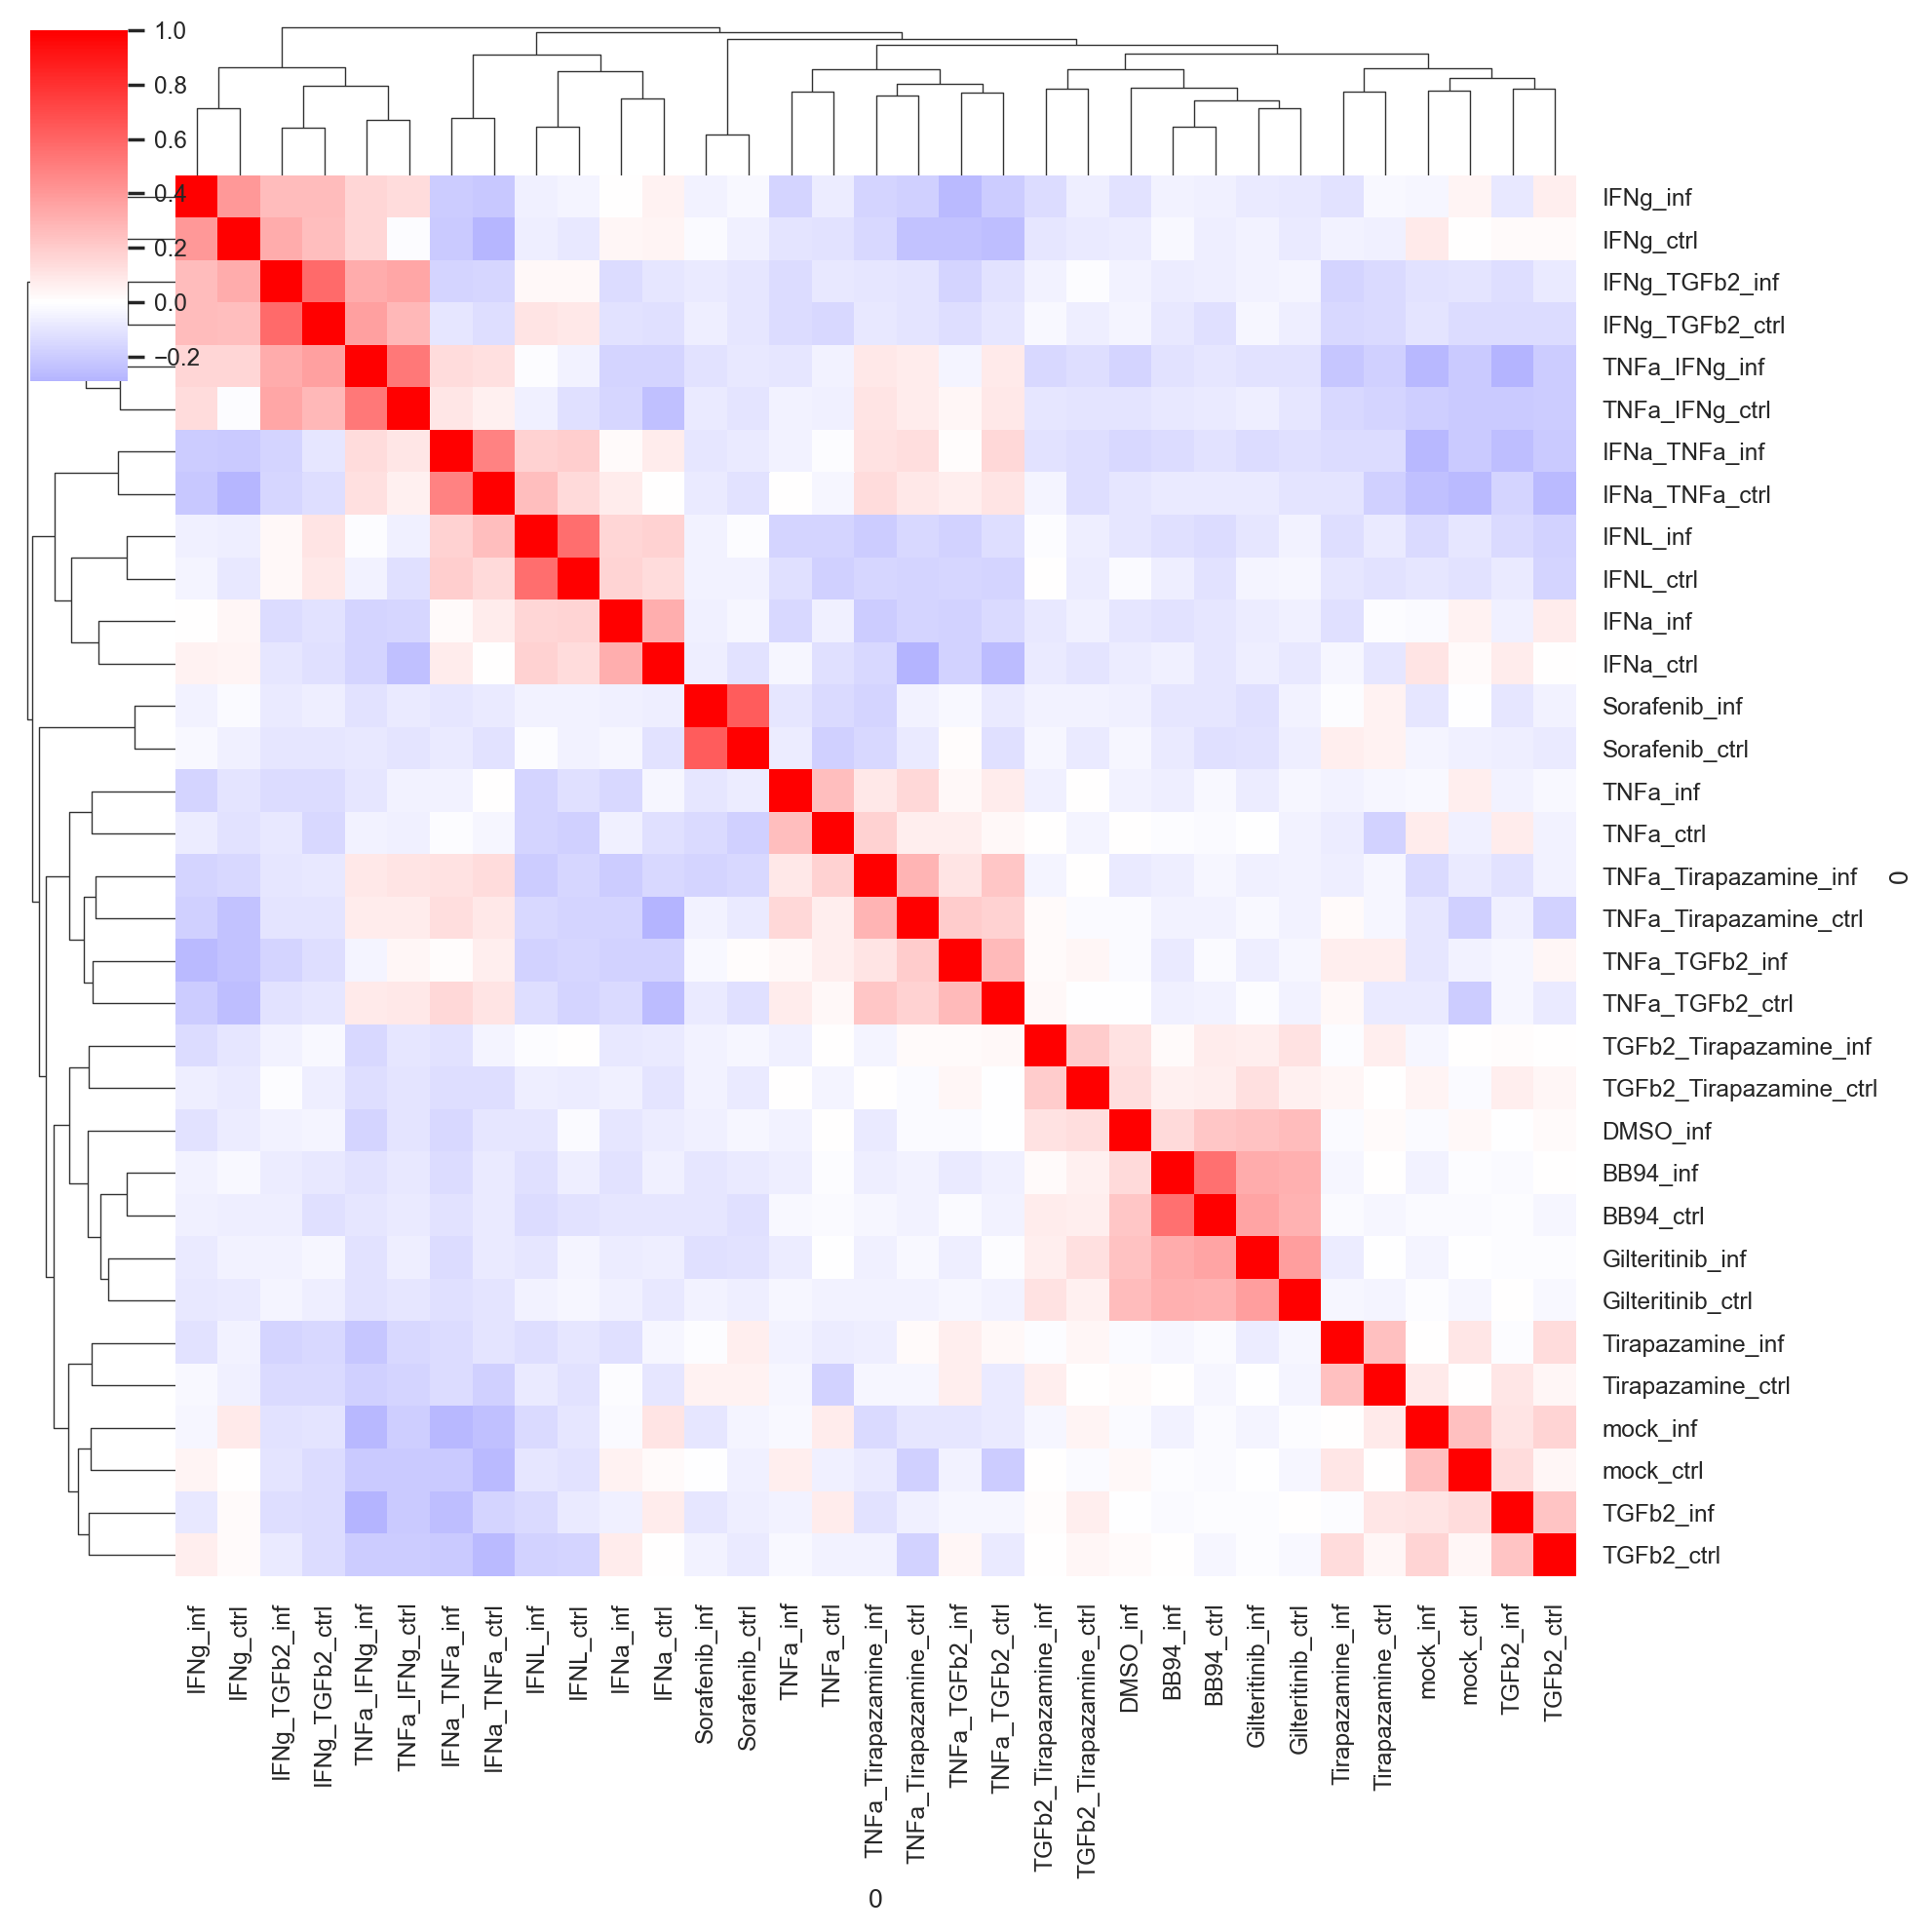

In [70]:
plt.figure(figsize=(10, 8))
g = sns.clustermap(coef_adata_df.corr('pearson'), cmap='bwr', center=0, dendrogram_ratio=.1, yticklabels=1)
g.ax_heatmap.tick_params(right=False, bottom=False)

In [88]:
inf_df = ad.AnnData(clf_inf.coef_,  var=adata.var, obs=pd.DataFrame(clf_inf.classes_).set_index(0)).to_df().T
ctrl_df = ad.AnnData(clf_ctrl.coef_, var=adata.var, obs=pd.DataFrame(clf_ctrl.classes_).set_index(0)).to_df().T
coef_diff_df = (inf_df-ctrl_df)/(inf_df+ctrl_df)
coef_diff_df.drop('DMSO', axis=1, inplace=True)  # only inf samples

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


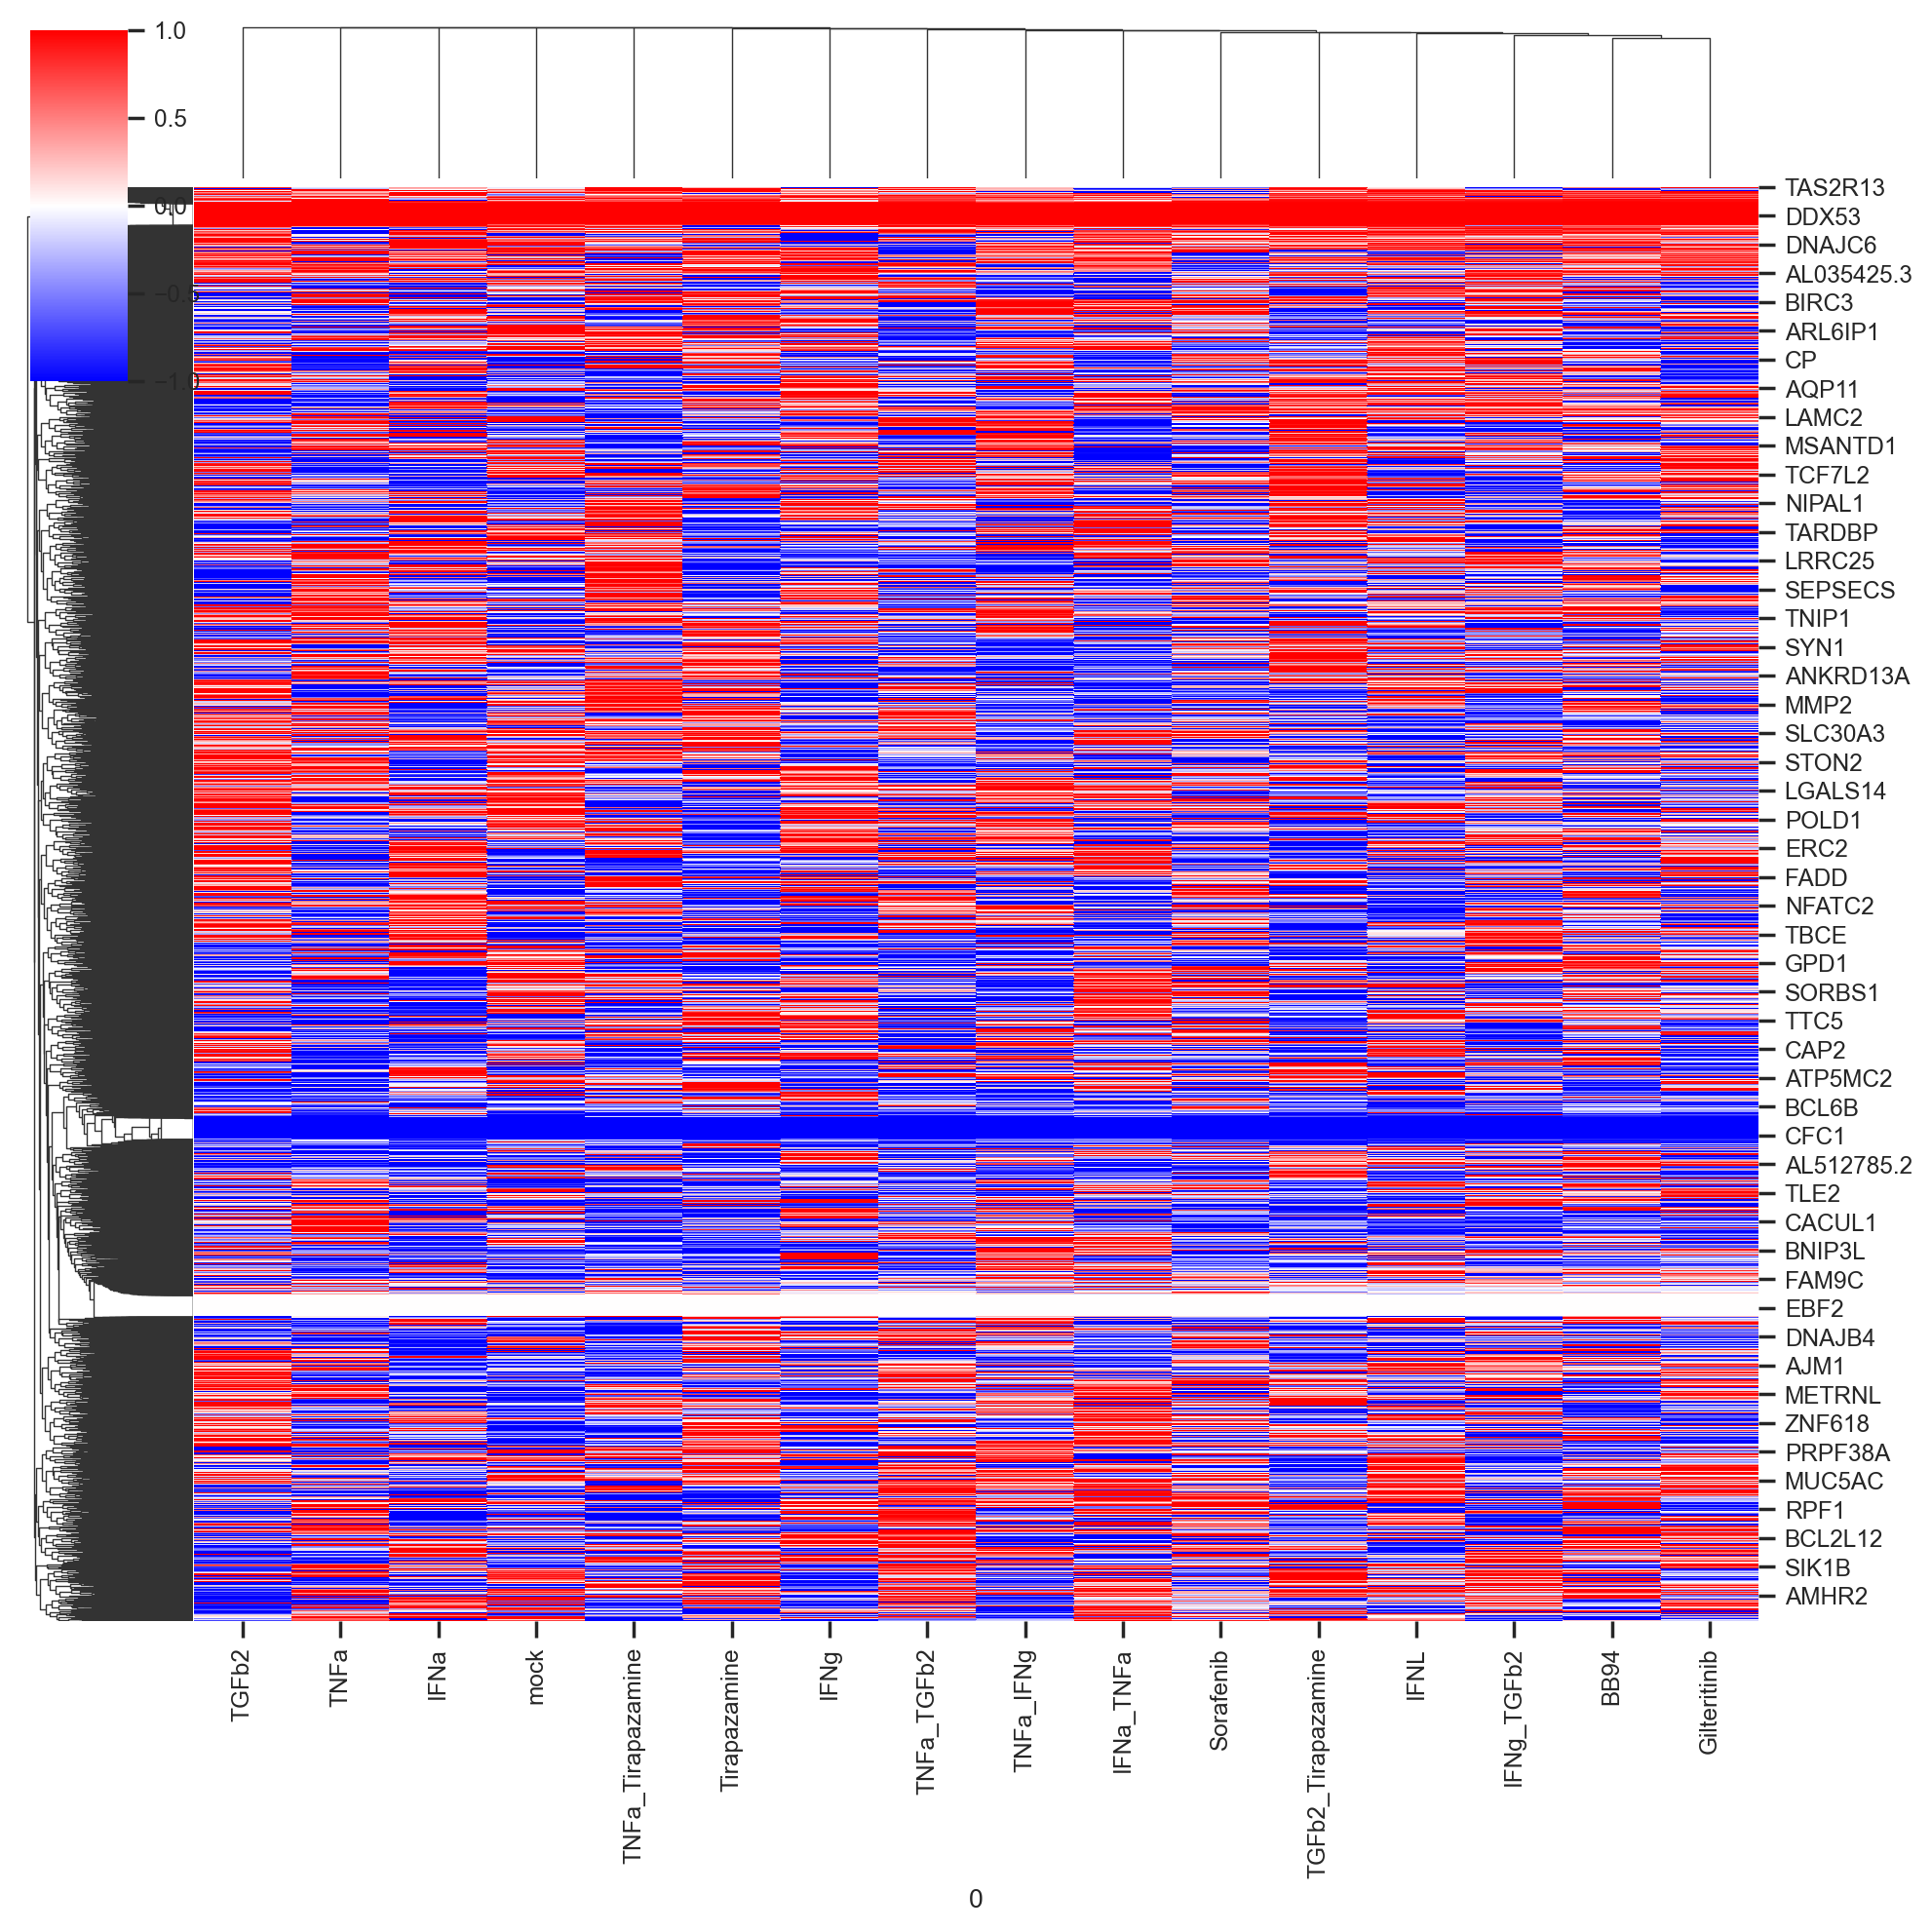

In [94]:
g = sns.clustermap(coef_diff_df.fillna(0).clip(-1, 1), cmap='bwr', center=0, dendrogram_ratio=.1)

In [95]:
top_diff_diff_genes = [g.ax_heatmap.yaxis.get_ticklabels()[i].get_text() for i in range(50)]

In [96]:
from utils import enrich
enrich(top_diff_diff_genes, adata.var_names)

,name,p_value,intersections


### compare single coefficients to doubles

In [15]:
# # make combos
# combos = ['IFNa_TNFa', 'TNFa_Tirapazamine', 'TNFa_TGFb2', 'TNFa_IFNg', 'IFNg_TGFb2', 'TGFb2_Tirapazamine']
# for c in combos:
#     coef_adata_df[f'{c}_combo'] = coef_adata_df[[c.split('_')[0], c.split('_')[1]]].sum(axis=1)

<AxesSubplot:xlabel='0', ylabel='0'>

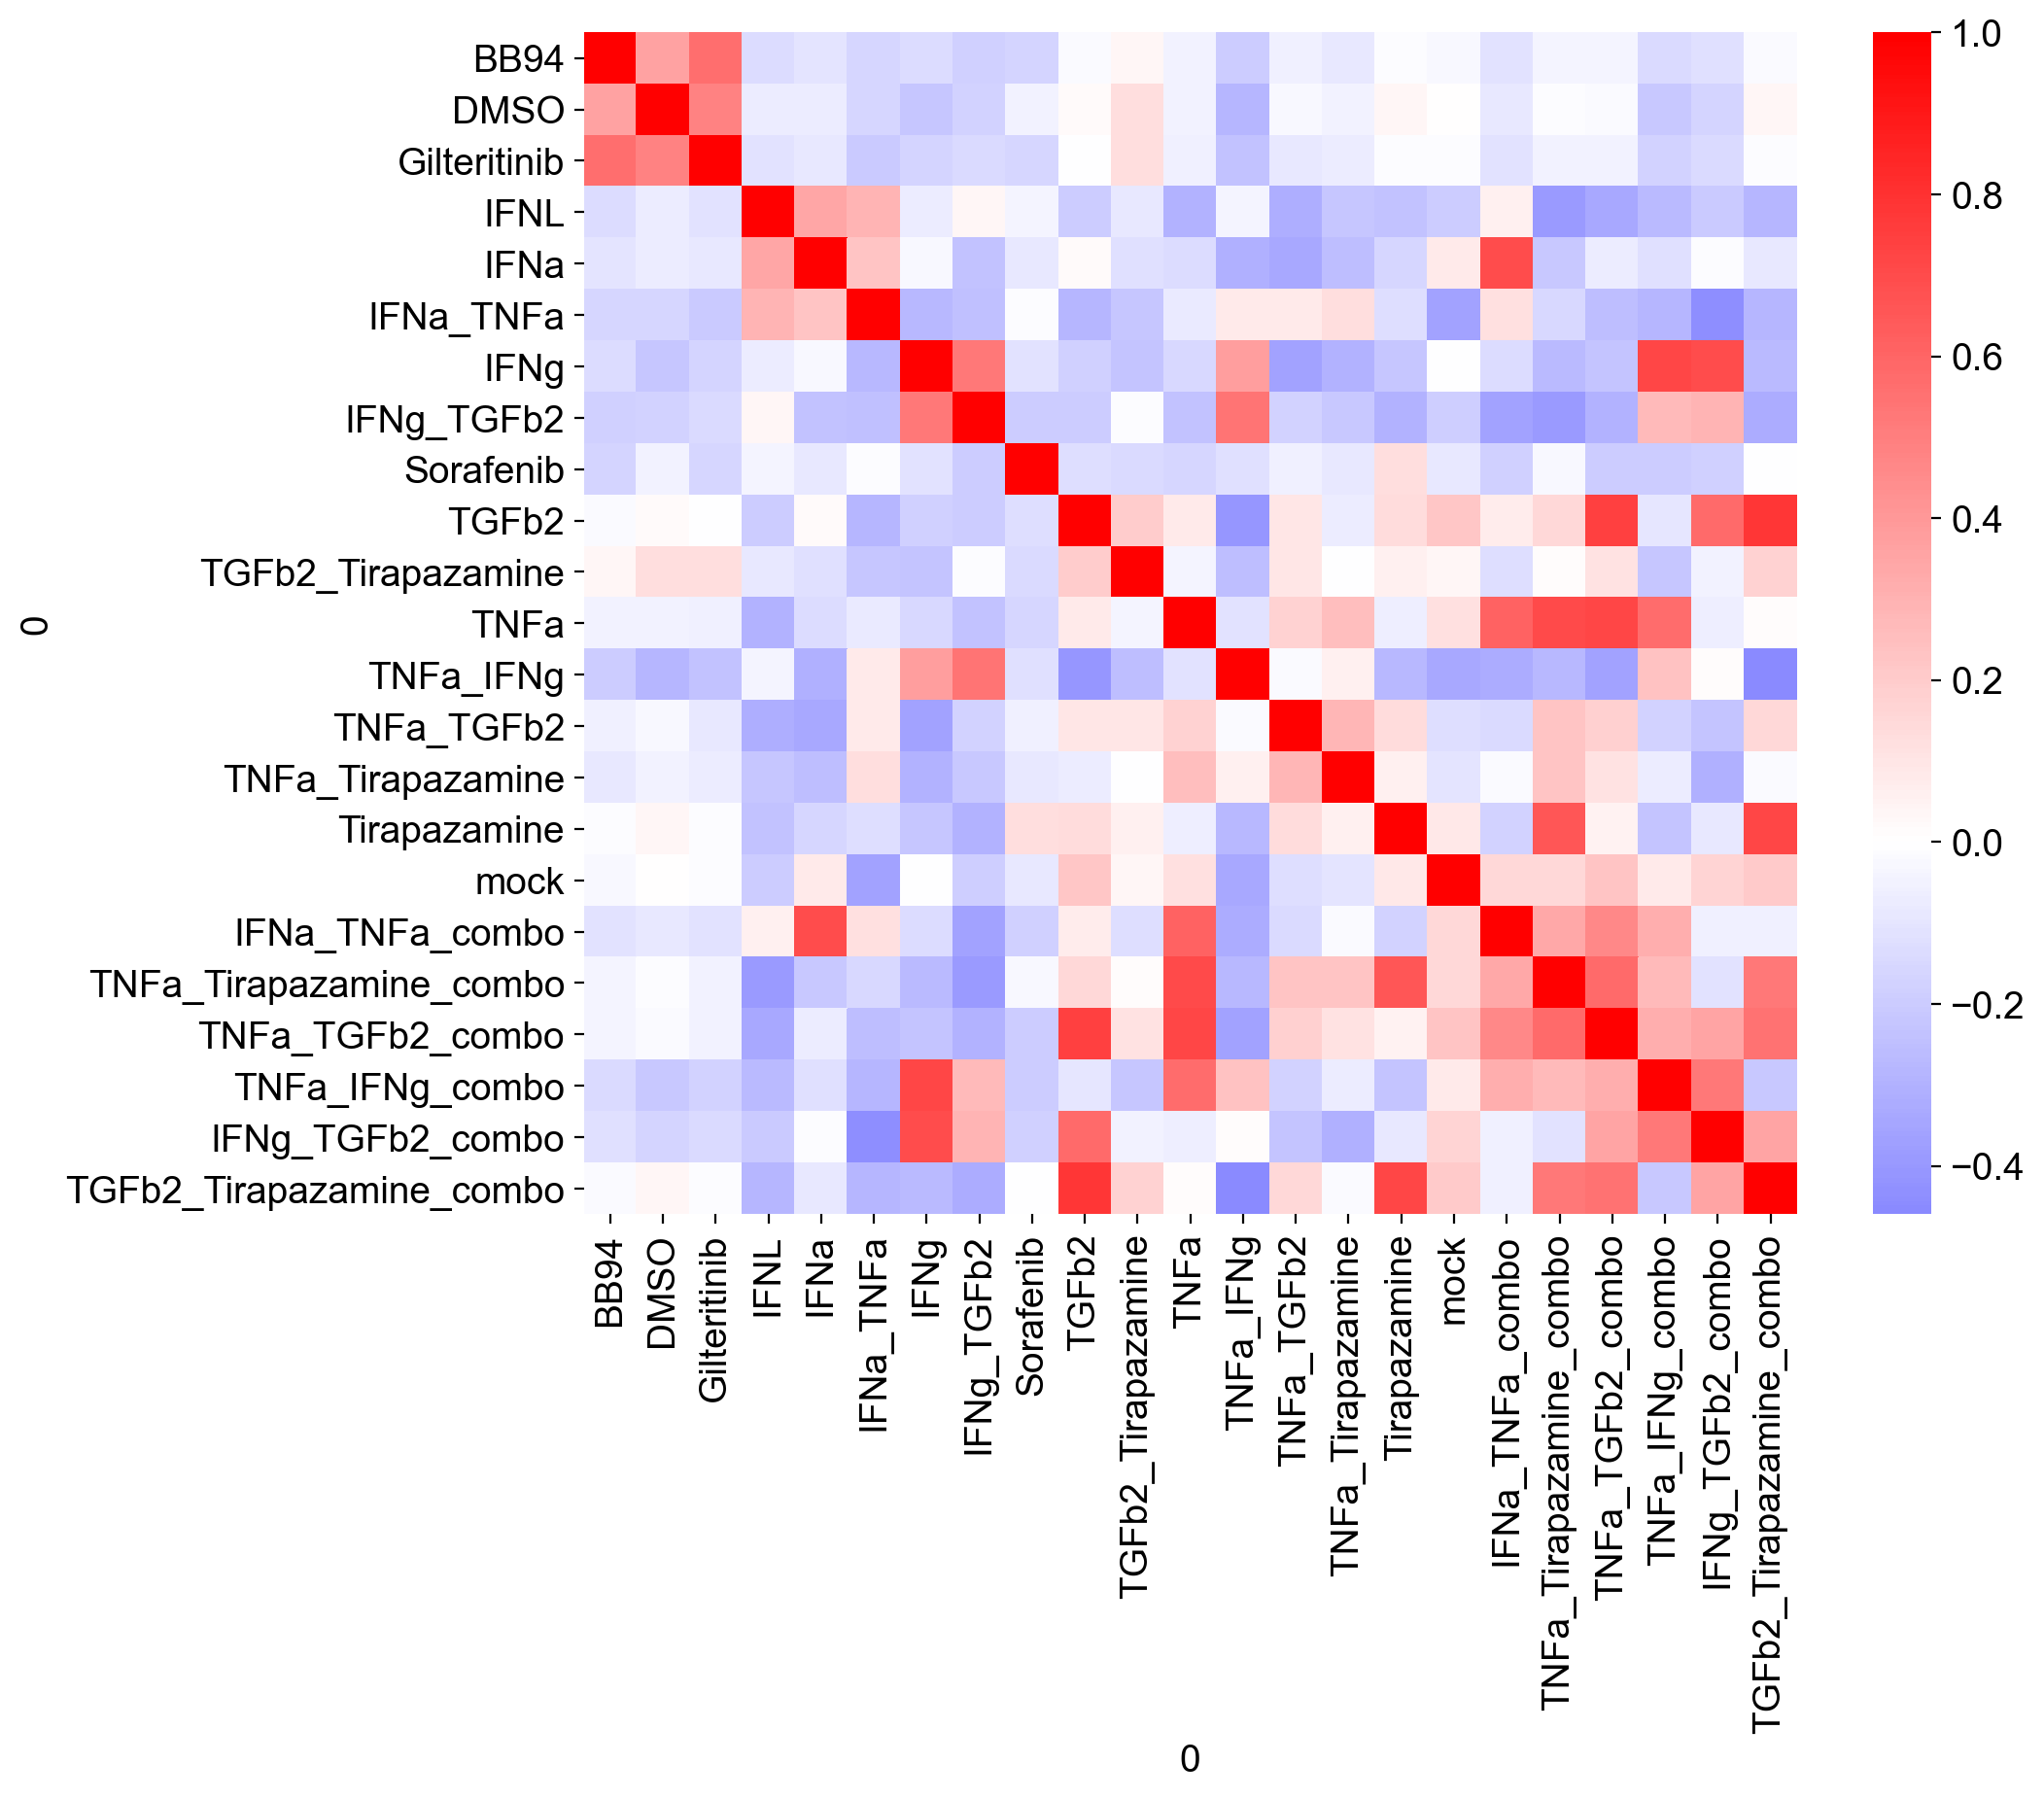

In [29]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(coef_adata_df.corr('pearson'), cmap='bwr', center=0)